## GPU Check

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8820167522323802850
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1747976192
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5179844665598089210
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [3]:
tf.test.gpu_device_name()  

'/device:GPU:0'

## Load Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Conv2DTranspose,BatchNormalization,LeakyReLU,ReLU,Reshape,Dropout,Flatten
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from tensorflow.keras.utils import plot_model
from PIL import Image

## Load Data

In [5]:
all_imgs = []
all_imgs_resized = []
PATH = './data/'
for img in os.listdir(PATH):
    all_imgs.append(np.array(img_to_array(load_img(PATH + img))))
    all_imgs_resized.append(np.array(img_to_array(load_img(PATH + img,target_size=(16,16)))))

In [6]:
all_imgs = np.array(all_imgs,dtype='float16')
all_imgs_resized = np.array(all_imgs_resized,dtype='float16')

In [7]:
all_imgs.shape,all_imgs_resized.shape

((21551, 64, 64, 3), (21551, 16, 16, 3))

In [8]:
all_imgs = all_imgs/127.5 - 1
all_imgs_resized = all_imgs_resized/127.5 - 1

In [9]:
all_imgs.max(),all_imgs.min()

(1.0, -1.0)

In [10]:
BATCH_SIZE = 8

In [11]:
dataset = tf.data.Dataset.from_tensor_slices(all_imgs_resized)
dataset = dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE,drop_remainder=True).prefetch(1)

## Visualize

In [47]:
def plot_img(images,n_col=None):
    n_col = n_col or len(images) 
    n_row = (len(images)-1)//(n_col-1)
    fig = plt.figure(figsize=(n_col,n_row))
    for idx,img in enumerate(images):
        plt.subplot(n_row,n_col,idx+1)
        img = (img+1)*127.5
        #print("img : ",type(img))
        img = img.astype(np.uint16)
        plt.imshow(img)
        plt.axis('off')

In [13]:
idx = np.random.randint(0,len(all_imgs_resized)-1,4)

In [14]:
idx

array([ 8608, 17446, 16738, 14155])

In [15]:
all_imgs_resized[idx].shape

(4, 16, 16, 3)

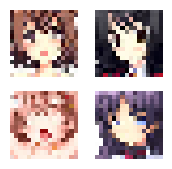

In [16]:
plot_img(all_imgs[idx],2)

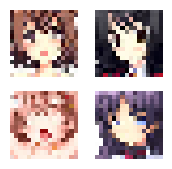

In [17]:
plot_img(all_imgs_resized[idx],2)

## Generator

In [18]:
NOISE = 100

In [19]:
generator = Sequential()
generator.add(Dense(4*4*512,activation=LeakyReLU(alpha=0.2),input_shape=[NOISE]))
generator.add(Reshape([4,4,512]))
generator.add(Conv2DTranspose(256,kernel_size=5,padding='same',strides=2,activation=LeakyReLU(alpha=0.2)))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(128,kernel_size=4,padding='same',strides=2,activation=LeakyReLU(alpha=0.2)))
generator.add(BatchNormalization())
#generator.add(Conv2DTranspose(64,kernel_size=3,padding='same',strides=2,activation=LeakyReLU(alpha=0.2)))
#generator.add(BatchNormalization())
generator.add(Conv2DTranspose(3,kernel_size=2,padding='same',activation='tanh'))
#generator.add(Conv2DTranspose(3,kernel_size=2,padding='same',strides=2,activation='tanh'))

In [20]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        3277056   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      524416    
 ranspose)                                                       
                                                        

In [21]:
plot_model(generator,show_layer_names=True,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Test Generator

the shape of image is (16, 16, 16, 3)


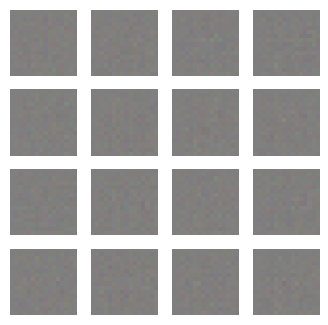

In [22]:
random_points = tf.random.normal([16,NOISE])
gen_imgs = generator(random_points)
plot_img(gen_imgs.numpy(),4)

print(f'the shape of image is {gen_imgs.shape}')

## Discriminator

In [23]:
discriminator = Sequential()
discriminator.add(Conv2D(256,kernel_size=3,activation=LeakyReLU(alpha=0.2),padding='same',input_shape=[16,16,3]))
discriminator.add(Dropout(0.2))
discriminator.add(Conv2D(128,kernel_size=4,activation=LeakyReLU(alpha=0.2),padding='same',strides=2))
discriminator.add(Dropout(0.1))
discriminator.add(Conv2D(64,kernel_size=3,activation=LeakyReLU(alpha=0.2),padding='same',strides=2))
discriminator.add(Dropout(0.2))
discriminator.add(Conv2D(32,kernel_size=2,activation=LeakyReLU(alpha=0.2),padding='same',strides=2))
discriminator.add(Dropout(0.1))
discriminator.add(Conv2D(16,kernel_size=2,activation=LeakyReLU(alpha=0.2),padding='same'))
discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))

In [24]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 256)       7168      
                                                                 
 dropout (Dropout)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         524416    
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          73792     
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 64)          0         
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 32)         

In [25]:
plot_model(discriminator,show_layer_names=True,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [26]:
discriminator.compile(optimizer='adam',loss='binary_crossentropy')

In [27]:
discriminator.trainable = False

## Create and train GAN

In [28]:
GAN = Sequential([generator,discriminator])

In [29]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [48]:
def gan_train(gan,dataset,epochs=30,random_points=100):
    gen,dis = gan.layers
    
    for epoch in range(1,epochs+1):
        print(f'Epoch: {epoch}/{epochs}')
        
        for real_imgs in dataset:
            batch_size = real_imgs.shape[0]
            data_points = tf.random.normal([batch_size,random_points])
            fake_imgs = gen(data_points)
            fake_imgs = tf.cast(fake_imgs,tf.float16)
            all_imgs = tf.concat([real_imgs,fake_imgs],axis=0)
            all_labels = tf.constant([[1.0]]*batch_size + [[0.]]*batch_size)
            
            dis.trainable = True
            dis.train_on_batch(all_imgs,all_labels)
            
            noise = tf.random.normal([batch_size,random_points])
            label = tf.constant([[1.]]*batch_size)
            dis.trainable = False
            gan.train_on_batch(noise,label)
        plot_img(fake_imgs.numpy(),2)
        plt.show()
            

Epoch: 1/20


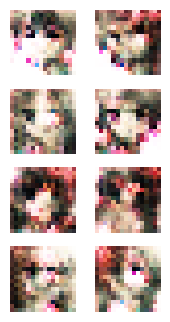

Epoch: 2/20


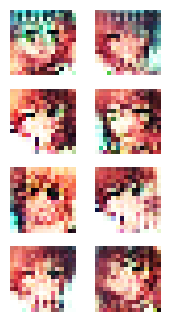

Epoch: 3/20


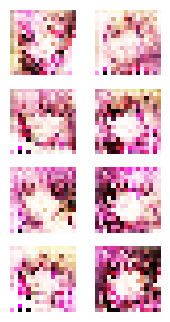

Epoch: 4/20


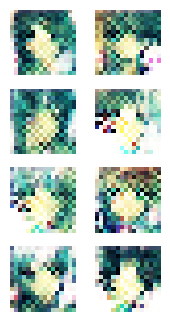

Epoch: 5/20


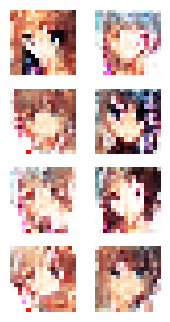

Epoch: 6/20


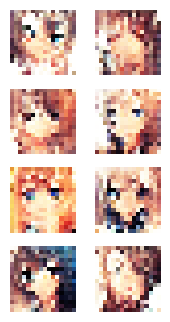

Epoch: 7/20


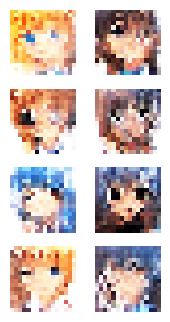

Epoch: 8/20


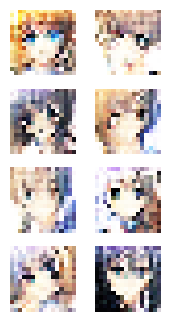

Epoch: 9/20


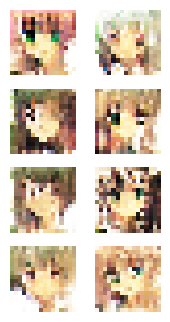

Epoch: 10/20


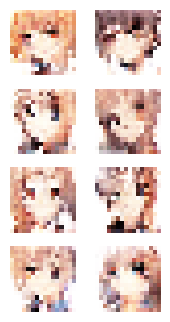

Epoch: 11/20


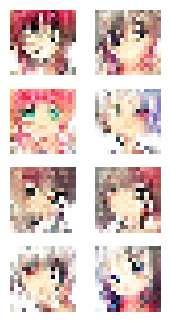

Epoch: 12/20


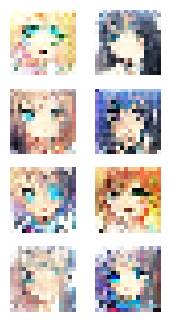

Epoch: 13/20


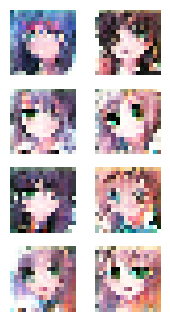

Epoch: 14/20


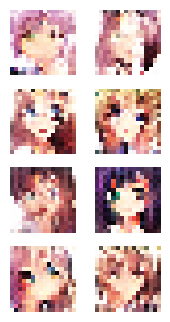

Epoch: 15/20


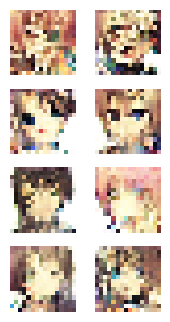

Epoch: 16/20


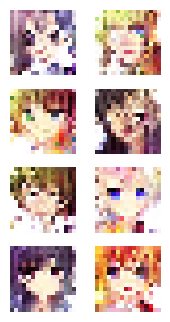

Epoch: 17/20


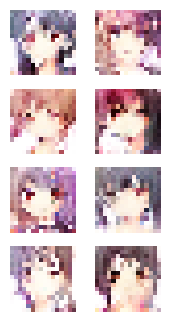

Epoch: 18/20


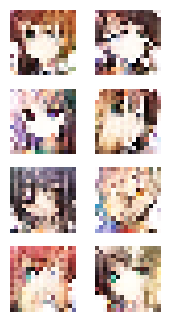

Epoch: 19/20


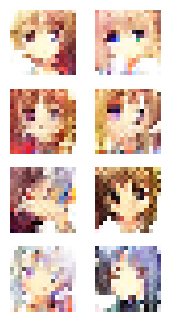

Epoch: 20/20


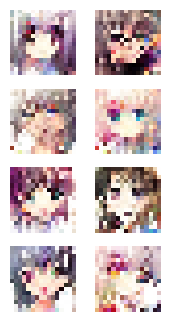

In [49]:
gan_train(GAN,dataset,20,100)

## Test GAN

In [50]:
data = tf.random.normal([100,100])
print(data)
gen_imgs = GAN.layers[0](data)

tf.Tensor(
[[ 1.3238654  -0.46973073 -0.3934538  ... -0.13589391 -1.5911074
  -1.2446668 ]
 [ 1.9844989   0.313049    1.6493293  ... -0.4009662  -0.48637563
  -1.1730144 ]
 [ 0.41836697  1.4782268   0.65563637 ... -0.48122722  0.6735521
  -0.09467162]
 ...
 [ 0.13475548  1.4709569   0.0954376  ... -0.62685394 -0.48372838
   1.4554292 ]
 [-0.5101301   1.8443407   0.9495362  ... -1.0178128   0.54772824
  -0.76904845]
 [-0.19974622  0.36181527  0.05876055 ... -2.091356    0.06906917
  -0.8006348 ]], shape=(100, 100), dtype=float32)


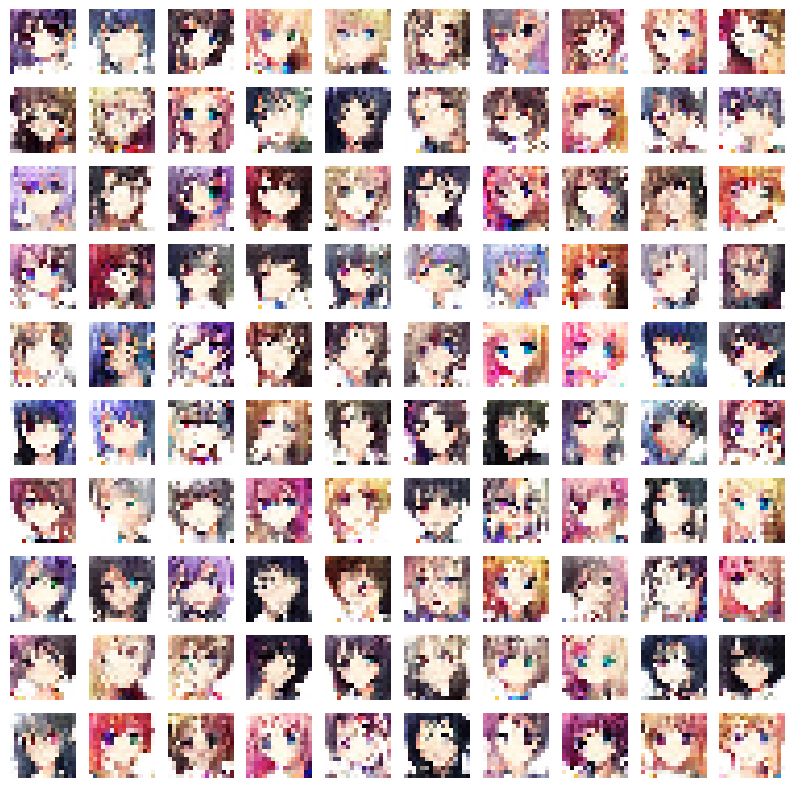

In [52]:
plot_img(gen_imgs.numpy(),10)